# SIFT Feature Detector



## Import Modules

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import scipy.signal
import scipy.linalg
import mae6292.tools as mae6292
import importlib

from mae6292.imshow import cv2_imshow

## SIFT Feature Detector

Consider [KITTI dataset](http://www.cvlibs.net/datasets/kitti/). We are going to perform feature extraction, description, and matching.

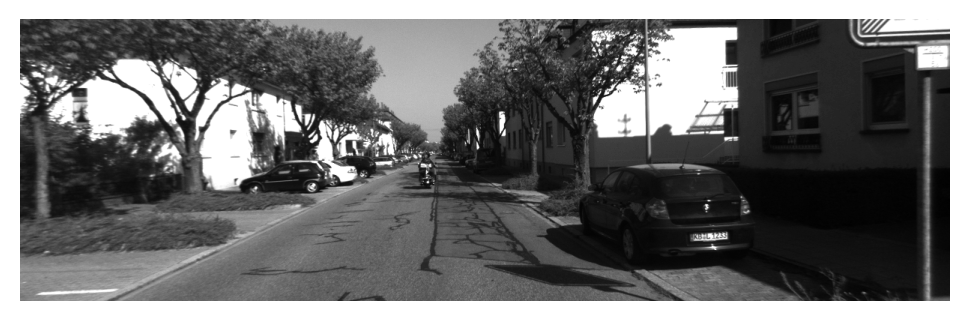

In [4]:
# resize_factor = 0.3
# img1 = cv2.resize(cv2.imread('data/img_1.jpg',cv2.IMREAD_GRAYSCALE), None, fx=resize_factor, fy=resize_factor)
# img2 = cv2.resize(cv2.imread('data/img_2.jpg',cv2.IMREAD_GRAYSCALE), None, fx=resize_factor, fy=resize_factor)
# cv2_imshow(img2)

img = cv2.imread('data/000000.png',cv2.IMREAD_GRAYSCALE)
cv2_imshow(img)

In [5]:
def create_image_pyramid(img, N_octaves, N_scales_per_octave, sigma = 1.6):
    
    img_downsample = []
    img_downsample.append(img)
    for i in range(N_octaves-1):
        img_downsample.append( cv2.resize(img_downsample[-1], None, fx=0.5, fy=0.5 ))    
    
    W = math.ceil(2*sigma) # default filter size for Gaussian 
    k = math.pow(2, 1/(N_scales_per_octave+2))
    
    img_pyramid = []
    for o in range(N_octaves):
        n_rows, n_cols = img_downsample[o].shape
        img_pyramid.append(np.zeros((n_rows,n_cols,N_scales_per_octave+3)))
        for s in range(N_scales_per_octave+3):
            filter_Gau_1D=cv2.getGaussianKernel(2*W+1, sigma*math.pow(k, s-1)).reshape(-1).astype('float32')
            img_pyramid[o][:,:,s] = scipy.signal.sepfir2d(img_downsample[o], filter_Gau_1D, filter_Gau_1D)
        
    return img_pyramid

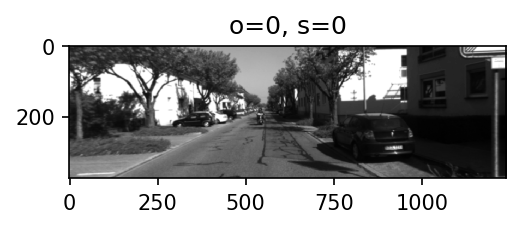

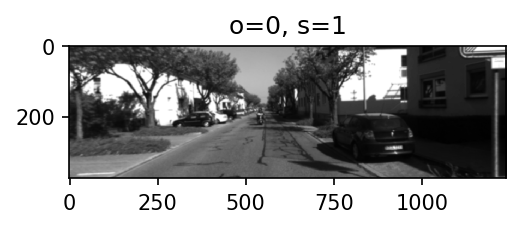

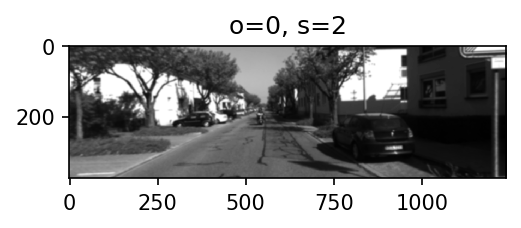

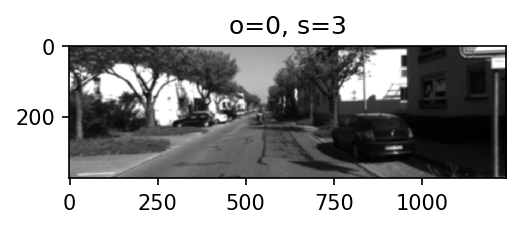

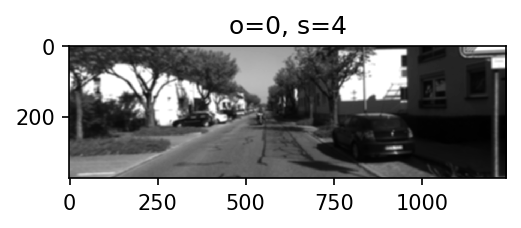

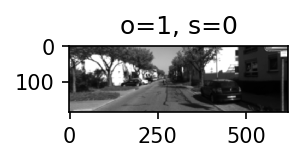

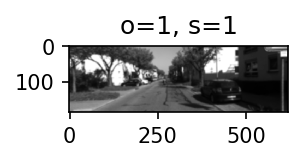

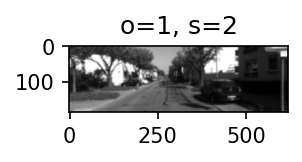

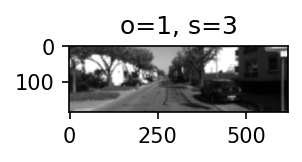

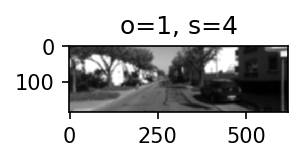

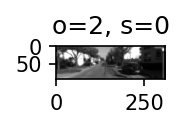

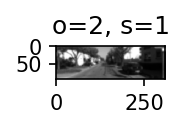

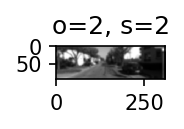

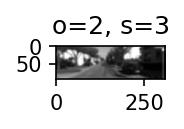

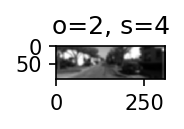

In [6]:
N_octaves = 3
N_scales_per_octave = 2
img_pyramid = create_image_pyramid(img, N_octaves, N_scales_per_octave)

for o in range(N_octaves):
    for s in range(N_scales_per_octave+3):
        height, width = img_pyramid[o][:,:,s].shape
        plt.figure(dpi=150, figsize=(height/100, width/100))
        plt.imshow(img_pyramid[o][:,:,s], cmap='gray', interpolation='none')
        plt.title('o='+str(o)+', s='+str(s))

In [7]:
def compute_DoG(image_pyramid):
    N_octaves = len(image_pyramid)
    N_scales_per_octave = image_pyramid[0].shape[2]-3
    DoG=[]
    for o in range(N_octaves):
        n_rows, n_cols, _ = image_pyramid[o].shape
        DoG.append(np.zeros((n_rows,n_cols,N_scales_per_octave+2)))
        for s in range(N_scales_per_octave+2):
            DoG[o][:,:,s]=image_pyramid[o][:,:,s+1]-image_pyramid[o][:,:,s]
            
    return DoG

DoG = compute_DoG(img_pyramid)


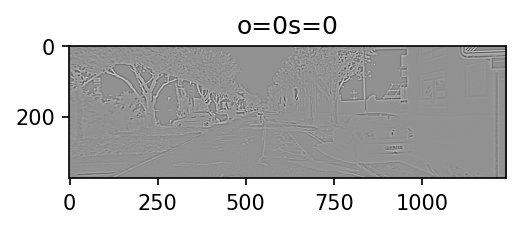

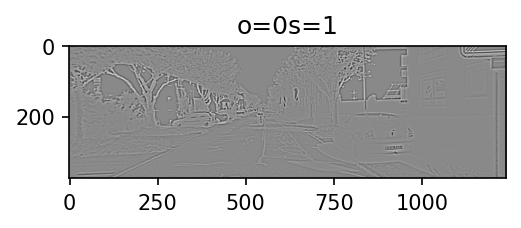

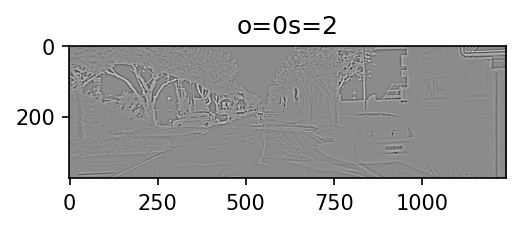

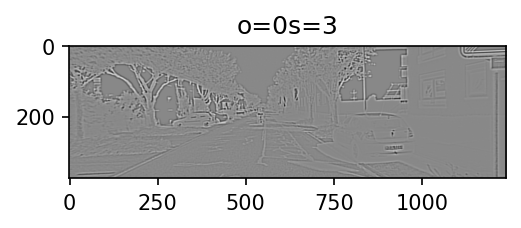

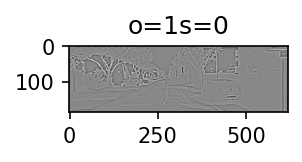

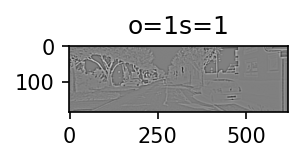

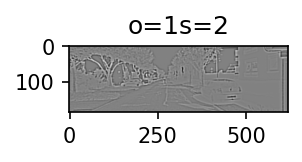

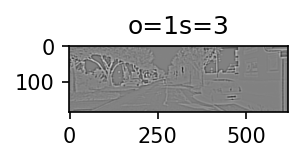

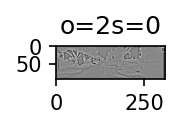

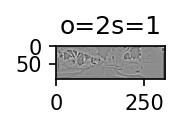

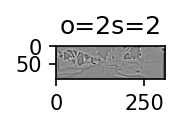

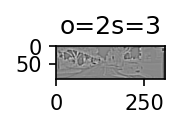

In [8]:
for o in range(N_octaves):
    for s in range(N_scales_per_octave+2):
        height, width = DoG[o][:,:,s].shape
        plt.figure(dpi=150, figsize=(height/100, width/100))
        plt.imshow(DoG[o][:,:,s], cmap='gray')
        plt.title('o='+str(o)+'s='+str(s))


In [9]:
def select_keypoints_DoG(DoG, threshold=0.04):
    N_octaves = len(DoG)
    N_scales_per_octave = DoG[0].shape[2]-2
    keypoints=[]
    for o in range(N_octaves):        
        DoGo_max = scipy.ndimage.morphology.grey_dilation(np.abs(DoG[o]), size=(3,3,3))        
        
        index = np.where((DoGo_max == np.abs(DoG[o])) & (DoGo_max > threshold))
        # stack list of arrays into 2D array
        index = np.vstack(index)
        # remove the max from the first and the last DOG in each octave
        index = index[:, np.where((index[2] > 0) & (index[2] < N_scales_per_octave))[0]]
        
        keypoints.append(index)
    return keypoints        

keypoints = select_keypoints_DoG(DoG,4)

158


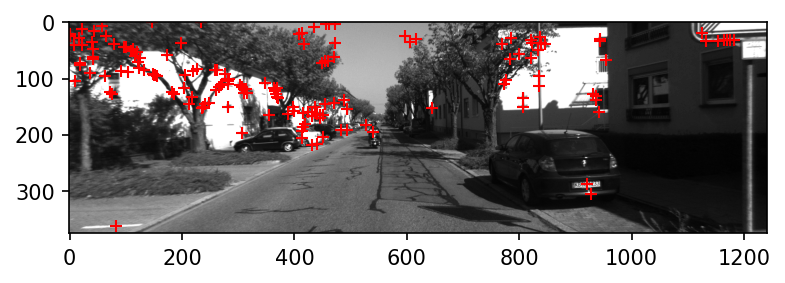

In [10]:
N_octaves = 5
N_scales_per_octave = 3
threshold_keypoints = 6

img_pyramid = create_image_pyramid(img, N_octaves, N_scales_per_octave)
DoG = compute_DoG(img_pyramid)
keypoints = select_keypoints_DoG(DoG,threshold_keypoints)

plt.figure(dpi=150)
plt.imshow(img, cmap='gray')
for o in range(N_octaves):
    plt.plot(keypoints[o][1,:],keypoints[o][0,:],'r+')

N_keypoints = sum([keypoints[o].shape[1] for o in range(N_octaves)])
print(N_keypoints)

## OpenCV SIFT Detector

In OpenCV, SIFT had been removed due to the patent issue. But, after the patent expired in 2020, it was reintorduced to [OpenCV 4.4.0](https://opencv.org/opencv-4-4-0/)

The SIFT class object is created by [cv2.SIFT_create()](https://docs.opencv.org/3.4.11/d7/d60/classcv_1_1SIFT.html#ad337517bfdc068ae0ba0924ff1661131)
```
SIFT = cv2.SIFT_create(nfeatures = 0, nOctaveLayers =3, sigma=1.6)
```
where `nfeatures` is the number of features to be detected. 




4.5.5


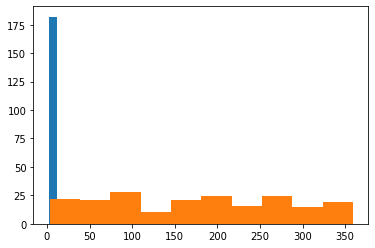

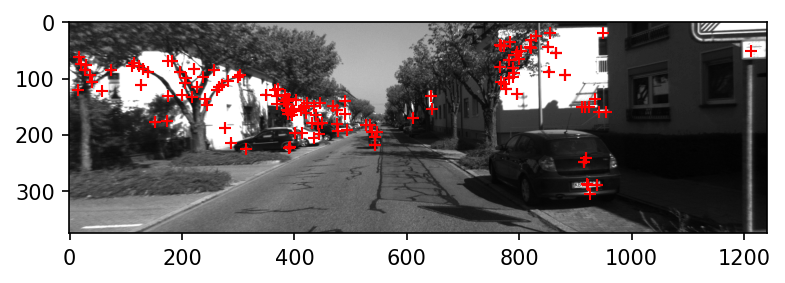

In [11]:
print(cv2.__version__)

SIFT = cv2.SIFT_create(nfeatures = 200)

keypoints_cv = SIFT.detect(img) 
# the above outptu kp is in OpenCV.Point2f format, we convert it back to list of tuples with (row,col)
keypoints = [p.pt[::-1] for p in keypoints_cv]
keypoints_scale = [p.size for p in keypoints_cv]
keypoints_angle = [p.angle for p in keypoints_cv]

plt.hist(keypoints_scale)
plt.hist(keypoints_angle)

plt.figure(dpi=150)
plt.imshow(img, cmap='gray')
keypoints_uv = list(zip(*keypoints))
plt.plot(keypoints_uv[1],keypoints_uv[0],'r+')



Or the keypoints canbe visulazed by [cv2.drawKeypoints()](https://docs.opencv.org/master/d4/d5d/group__features2d__draw.html#ga5d2bafe8c1c45289bc3403a40fb88920), together with the size and the orientation of the keypoints.
                                     

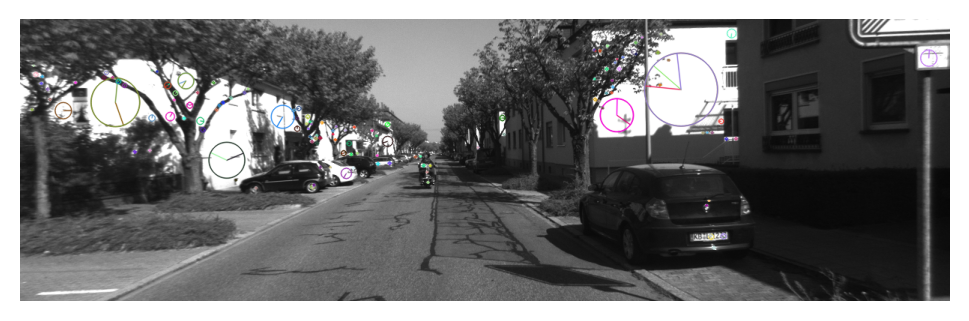

In [12]:
# img_keypoints = cv2.drawKeypoints(img,keypoints_cv,img.copy())
img_keypoints = cv2.drawKeypoints(img,keypoints_cv,img.copy(), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

cv2_imshow(img_keypoints)


## OpenCV SIFT Descriptor

Two tasks of the feature dection and description are completed by the single command `SIFT.detectAndCompute()`. The resulting descriptor size is `Number of keypoints x 128`

In [13]:
keypoints_cv, descriptors = SIFT.detectAndCompute(img,None)
keypoints = [p.pt[::-1] for p in keypoints_cv]
keypoints_scale = [p.size for p in keypoints_cv]
keypoints_angle = [p.angle for p in keypoints_cv]

print(len(keypoints))
print(len(keypoints_scale))
print(len(keypoints_angle))
print(descriptors.shape)
print(descriptors.dtype)

200
200
200
(200, 128)
float32


In [14]:
print(descriptors[0,:])

[  4.  14.  11.  10.   2.   0.   0.   3.  11.  12.   7.   1.   0.   0.
  21.  34.  20.   4.   1.   2.   1.  11.  60.  19.  27.   9.   5.  10.
   3.   6.  16.  12.  37.   2.   1.   2.   7.   4.   1.  31. 125.  24.
   6.   6.   4.   6.  80. 125.  15.   8.   8.  57. 112. 101. 125.  67.
  22.   8.   5.  18.  30.  29.  43.  21.  49.  11.   0.   2.   7.   2.
   1.  11. 125. 125.  85.  24.   3.   2.   4.  36.  19.  36.  96. 125.
  82.   9.  20.  35.  64.  24.   1.  20.  17.   4.  35.  68.  14.   9.
   3.   1.   0.   1.   1.  12.  24.  29.  12.   2.   0.   0.  28. 125.
   2.   4.  14.  14.   4.   1. 125. 125.   4.   0.   0.  47.  39.  11.
  94. 105.]


## OpenCV Feature Matching

OpenCV provides several methods for [feature mathcing](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_matcher/py_matcher.html). 
```
BFM = cv2.BFMatcher_create(cv2.NORM_L2, crossCheck=True)
matches = BFM.match(descriptors1, descriptors)
```

The output is a list of DMatch objects with the following attributes:

* DMatch.distance - Distance between descriptors. The lower, the better it is.
* DMatch.queryIdx - Index of the descriptor in query (`descriptors1`)
* DMatch.trainIdx - Index of the descriptor in database (`descriptors`)


(array([28., 35., 21.,  7.,  9., 10.,  7.,  4.,  1.,  1.]),
 array([ 25.3771553 ,  65.02545662, 104.67375793, 144.32205925,
        183.97036057, 223.61866188, 263.2669632 , 302.91526451,
        342.56356583, 382.21186714, 421.86016846]),
 <BarContainer object of 10 artists>)

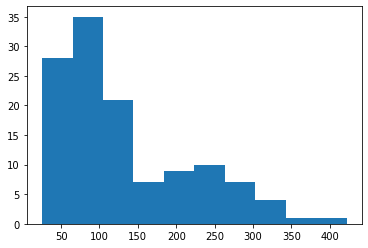

In [15]:
img1 = cv2.imread('data/000001.png',cv2.IMREAD_GRAYSCALE)
keypoints1_cv, descriptors1 = SIFT.detectAndCompute(img1,None)

# create an object for Brutal-Force matcher with L2 norm. 
BFM = cv2.BFMatcher_create(cv2.NORM_L2, crossCheck=True)

# match descriptors and sort it from the closest distance to the farthest
matches = BFM.match(descriptors1, descriptors)
matches = sorted(matches, key = lambda x:x.distance)

# distance variable for the matched pairs
distance=[m.distance for m in matches]
plt.hist(distance)

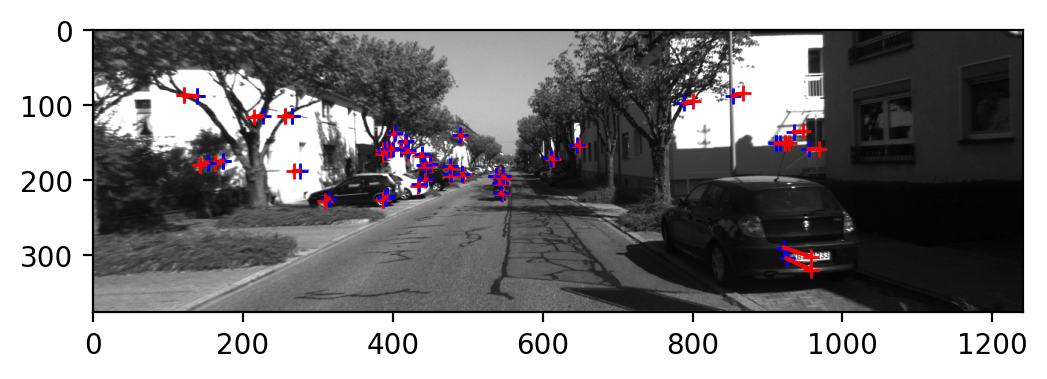

In [16]:
plt.figure(dpi=200)
plt.imshow(img1, cmap='gray')
for m in matches[:50]:
    v1, u1 = keypoints1_cv[m.queryIdx].pt # matched keypoints on img1
    v, u = keypoints_cv[m.trainIdx].pt # matched keypoints on img
    
    plt.plot(v1, u1, 'r+') 
    plt.plot(v, u, 'b+')
    plt.plot([v,v1],[u,u1],'r')
    
    

The matched keypoints can be also displayed by [cv2.drawMatches()](https://docs.opencv.org/master/d4/d5d/group__features2d__draw.html#ga62fbedb5206ab2faf411797e7055c90f)

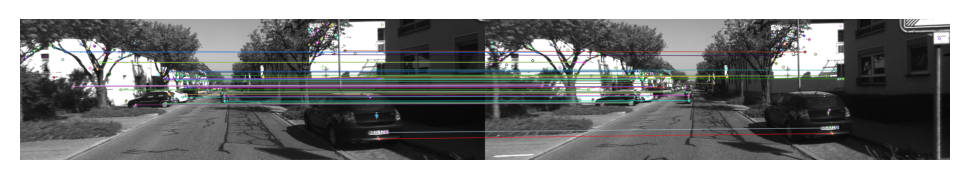

In [17]:
img_match = cv2.drawMatches(img1,keypoints1_cv,img,keypoints_cv,matches[:50], img.copy())

cv2_imshow(img_match)

## SIFT Ratio Test

[cv2.knnMatch()](https://docs.opencv.org/3.4/db/d39/classcv_1_1DescriptorMatcher.html#a378f35c9b1a5dfa4022839a45cdf0e89) can be used to detect the best $n$ matches. 
But, to use that function, the option `crossCheck` should be turned off first. 



Number of matches= 114


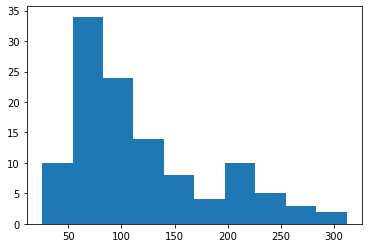

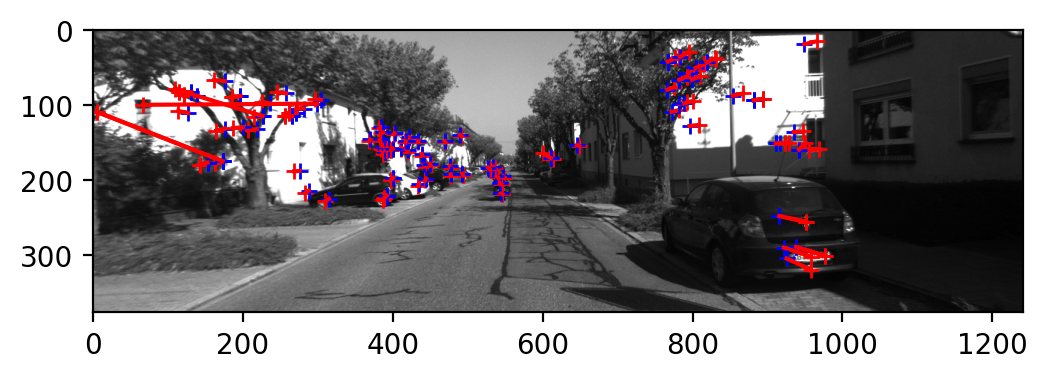

In [18]:
BFM = cv2.BFMatcher_create(cv2.NORM_L2, crossCheck=False)
matches = BFM.knnMatch(descriptors1,descriptors, k=2)

ratio_threshold = 0.6
good_matches = []
distance = []
for m,n in matches:
    # accept the matches if the distance ratio is less than the threshold
    if m.distance < ratio_threshold*n.distance:
        good_matches.append(m)
        distance.append(m.distance)

print('Number of matches=',len(good_matches))
plt.hist(distance)

plt.figure(dpi=200)
plt.imshow(img1, cmap='gray')
for m in good_matches:
    v1, u1 = keypoints1_cv[m.queryIdx].pt # matched keypoints on img1
    v, u = keypoints_cv[m.trainIdx].pt # matched keypoints on img
    
    plt.plot(v1, u1, 'r+') 
    plt.plot(v, u, 'b+')
    plt.plot([v,v1],[u,u1],'r')

## Feature Detection and Matching Over Time

The above process is repeated for 100 images.

In [ ]:
ratio_threshold = 0.4

BFM = cv2.BFMatcher_create(cv2.NORM_L2, crossCheck=False)
img_prev = cv2.imread('data/000000.png',cv2.IMREAD_GRAYSCALE)
keypoints_prev, descriptors_prev = SIFT.detectAndCompute(img_prev,None)

for k in range(99):
    load_filename = "data/{:06d}.png".format(k+1)
    img_curr = cv2.imread(load_filename,cv2.IMREAD_GRAYSCALE)
    keypoints_curr, descriptors_curr = SIFT.detectAndCompute(img_curr,None)
    matches = BFM.knnMatch(descriptors_curr,descriptors_prev, k=2)
    
    good_matches = []
    distance = []
    for m,n in matches:
        # accept the matches if the distance ratio is less than the threshold
        if m.distance < ratio_threshold*n.distance:
            good_matches.append(m)
            distance.append(m.distance)

    cv2_imshow(img_curr)
    for m in good_matches:
        v1, u1 = keypoints_curr[m.queryIdx].pt # matched keypoints on img1
        v, u = keypoints_prev[m.trainIdx].pt # matched keypoints on img

        plt.plot(v1, u1, 'r+') 
        plt.plot(v, u, 'b+')
        plt.plot([v,v1],[u,u1],'r')
    
    img_prev, keypoints_prev, descriptors_prev = img_curr, keypoints_curr, descriptors_curr
    
    save_filename = "data/feature_{:06d}.png".format(k+1)
    plt.savefig(save_filename, bbox_inches='tight', pad_inches=0)
    plt.close()

The above results can be saved into a video.

In [ ]:
# get image height and width from the first frame
k=0
save_filename = "data/feature_{:06d}.png".format(k+1)
frame = cv2.imread(save_filename) 
height, width, layers = frame.shape   

# create video writer with 10 fps
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter("feature.mp4", fourcc, 10, (width, height))   

# add frames
for k in range(99):
    save_filename = "data/feature_{:06d}.png".format(k+1)
    video.write(cv2.imread(save_filename))
      
# Deallocating memories taken for window creation 
cv2.destroyAllWindows()  
video.release()  # releasing the video generated 

## How to Improve?

1. Of course, we can play with the various parameters in keypoint selection and matching. It is alwasy better to have more features points with closer distance (similarity).
    * If the criteria are too loose, we may have false matches.
    * If the criteria are too tight, we end up with fewer of matches.
2. So far, the keypoints are matched using the similarity of image patches. However, we are matching features between sequential images. Assuming that the frame rate is relatively faster than the speed of the camera, we can expect that the matched features wouldn't move much in the pixel coordinates. In other words, we can discard features that moved two far.